### Import appropriate libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

### Measuring Treatment Outcomes
In this notebook, we will use the clinical data to measure treatment outcomes in accordance with FDA guidelines.  Listed as follows:<br>
<br>
Change in drug use pattern is the most commonly used endpoint in registration trials for drugs in development to treat OUD.<br> 
<br>
One method is to define a responder as a patient who reduces the use of opioids to or below a threshold known to be associated with clinical benefit. <br>
<br>
FDA recommends that sponsors compare percentage of responders rather than group means.  A successful trial would show either a higher percentage of responders in the treatment arm (for superiority trials) or noninferiority in the percentage of responders (for active-controlled noninferiority trials).<br>
<br>
A commonly used definition for a responder is abstinence, defined as no detected or self-
reported use during the specific assessment window.<br>
<br>
absence of positive urine drug tests, absence of self-reported drug use, and attendance at frequent scheduled observations for these measures are components of a complete abstinence response definition.<br>




### Read in the data

In [3]:
data = pd.read_csv('../notebooks.v2/data/merged_data.csv')

print(f'Shape of data df: {data.shape}')
display(data[:5]) # observe the first 5 rows of the data

Shape of data df: (1305, 558)


,patdeid,admin_location_0,methadone_dose_0,bupe_dose_0,admin_location_1,methadone_dose_1,bupe_dose_1,admin_location_2,methadone_dose_2,bupe_dose_2,...,race_amer_ind,race_Asian,race_Black,race_pacific_isl,race_White,medication,total_visits,tnt,wsu,responder
0,1,1.0,0.0,8.0,1.0,0.0,160.0,1.0,0.0,320.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,20,8,1
1,2,1.0,0.0,8.0,2.0,0.0,48.0,1.0,0.0,48.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,6,0,0
2,3,1.0,30.0,0.0,1.0,170.0,0.0,1.0,310.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,26,0,0,0
3,4,1.0,0.0,16.0,1.0,0.0,152.0,1.0,0.0,192.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,4,1,0
4,6,1.0,0.0,16.0,1.0,0.0,8.0,1.0,0.0,8.0,...,0.0,0.0,0.0,0.0,1.0,2.0,3,0,0,0


### Analyze treatment retention
Extract total visits for each patient and aggregate count of patients for each week

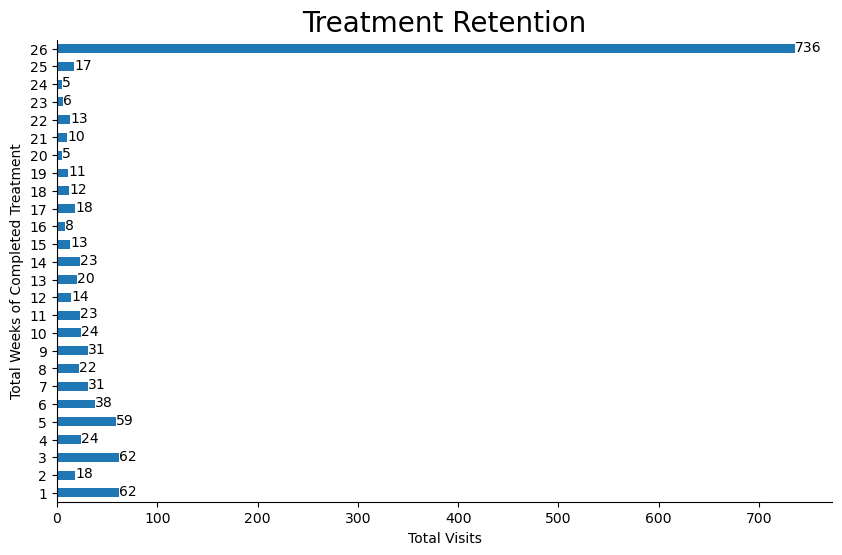

In [4]:
# extract total visits for each patient and aggregate by count
treatment_retention = data.total_visits.value_counts().sort_index(ascending=True)

# plot the data for visualization
ax = treatment_retention.plot(kind='barh', figsize=(10,6))
ax.set_title('Treatment Retention', fontsize=20)
ax.set_xlabel('Total Visits')
ax.set_ylabel('Total Weeks of Completed Treatment')

# annotate the bars for better interpretability
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.1, str(round((i.get_width()), 2)), fontsize=10, color='black')

# remove the borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Analyze Treatment Retention by Drug Class

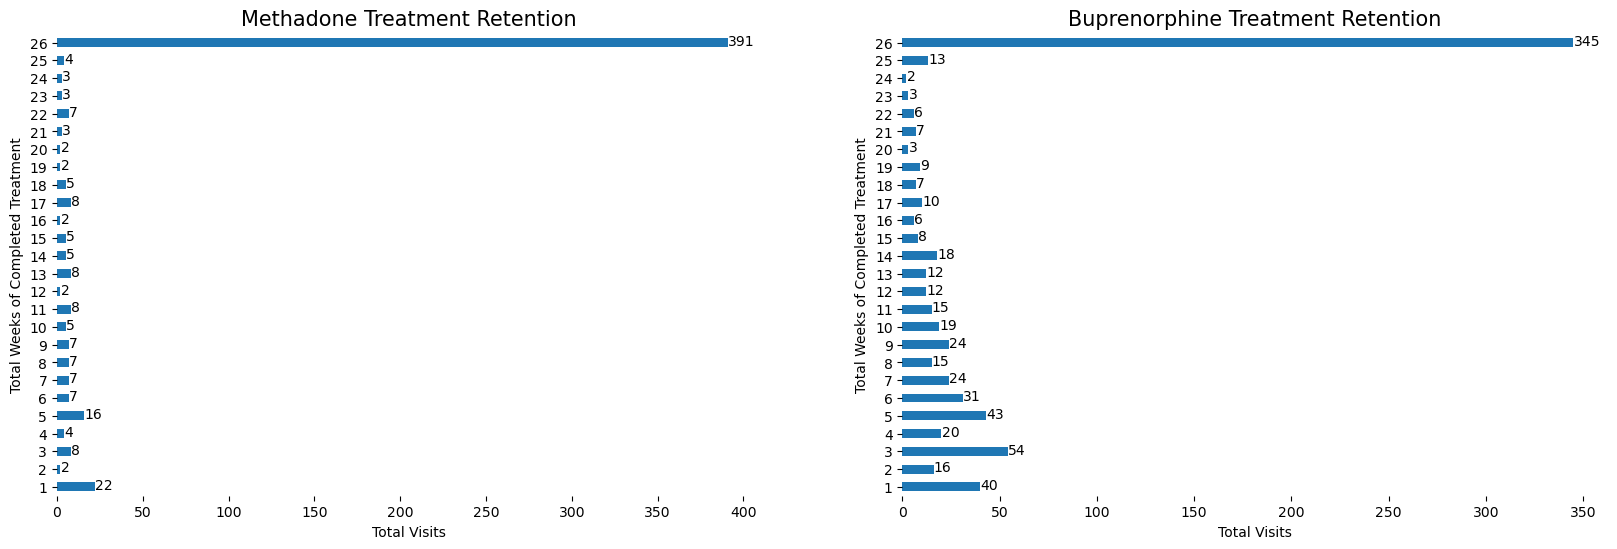

In [5]:
# create dataframes for treatment retention by drug class
methadone_ret = data.loc[data.medication==1].total_visits.value_counts().sort_index(ascending=True)
buprenorphine_ret = data.loc[data.medication==2].total_visits.value_counts().sort_index(ascending=True)

# plot the data for visualization
fig, ax = plt.subplots(1,2, figsize=(20,6))
methadone_ret.plot(kind='barh', ax=ax[0])
buprenorphine_ret.plot(kind='barh', ax=ax[1])
ax[0].set_title('Methadone Treatment Retention', fontsize=15)
ax[1].set_title('Buprenorphine Treatment Retention', fontsize=15)
ax[0].set_xlabel('Total Visits')
ax[1].set_xlabel('Total Visits')
ax[0].set_ylabel('Total Weeks of Completed Treatment')
ax[1].set_ylabel('Total Weeks of Completed Treatment')

# annotate the bars for better interpretability
for i in ax[0].patches:
    ax[0].text(i.get_width()+.1, i.get_y()+.1, str(round((i.get_width()), 2)), fontsize=10, color='black')

for i in ax[1].patches:
    ax[1].text(i.get_width()+.1, i.get_y()+.1, str(round((i.get_width()), 2)), fontsize=10, color='black') 

# remove the borders
sns.despine(left=True, bottom=True)
plt.show()

### We will observe treatment outcomes for those that completed all 24 weeks of treatment

In observing the chart above, it's clear there is major dropout risk for weeks 1, 3, 5 and 6

### Helper Functions
We will create 2 helper functions
1.  test_df() - creates a dataframe for a test or survey by drug class
2.  test_plot() - plots the results for easy interpretation

In [6]:
def test_df(prefix, drug_class):
    """
    Extracts and aggregates test results or self reported use by week of treatment.

    Args:
        prefix (str): The prefix indicating the type of data ('survey' or 'test').
        test_string (str): The specific test string to extract.

    Returns:
        pandas.DataFrame: A DataFrame containing the aggregated sum of positive opiate tests for each column.
    """
    # assert prefix is either 'survey' or 'treatment'
    assert prefix in ['survey', 'test'], 'prefix must be either survey or test'

    if prefix == 'survey':
        prefix = 'sru'
    else:
        prefix = 't' 

    # extract positive opiate tests for each week of treatment
    test = data.loc[:,['patdeid']+[col for col in data.columns if prefix+'_'+drug_class+'_' in col]]

    # remove the prefix from the column names
    test.columns = test.columns.str.replace(prefix+'_'+drug_class+'_', '')

    # create sum dictionary for each column
    test_dict = {col:'sum' for col in test.columns if col != 'patdeid'}

    # use groupby with patdeid as index and test_dict as columns
    test = test.groupby('patdeid').agg(test_dict)

    # aggregate the sum of positive tests or surveys for each column
    test = test.sum()

    # turn into dataframe
    test = pd.DataFrame(test)

    # rename column prefix + '_' 
    test.columns = [prefix+'_'+drug_class]

    return test

In [7]:
def test_plot(prefix, drug_class):
    """
    Plots a time series of positive opiate tests or self-reported use for each week of treatment.

    Args:
        prefix (str): The prefix indicating the type of data. Must be either 'survey' or 'test'.
        drug_class (str): The drug class to analyze.

    Raises:
        AssertionError: If the prefix is not 'survey' or 'test'.

    Returns:
        None
    """
    # assert prefix is either 'survey' or 'test'
    assert prefix in ['survey', 'test'], 'prefix must be either survey or test'

    if prefix == 'survey':
        prefix = 'sru'
    else:
        prefix = 't'


    # extract positive opiate tests for each week of treatment
    test = data.loc[:,['patdeid']+[col for col in data.columns if prefix+'_'+drug_class+'_' in col]]

    # remove the prefix from the column names
    test.columns = test.columns.str.replace(prefix+'_'+drug_class+'_', '')

    # create sum dictionary for each column
    test_dict = {col:'sum' for col in test.columns if col != 'patdeid'}

    # use groupby with patdeid as index and test_dict as columns
    test = test.groupby('patdeid').agg(test_dict)

    # aggregate the sum of positive opiate tests for each column
    test = test.sum()

    # replace "Tests" with "Self Reported Use" in the title
    if 'sru' in prefix:
        plot_type = 'Self Reported Use'
    else:
        plot_type = 'Positive Tests'

    # for test_string, make first letter uppercase
    drug_class = drug_class[0].upper() + drug_class[1:]

    # plot time series of positive opiate tests
    ax = test.plot(kind='bar', figsize=(10,6), title=f'{drug_class} {plot_type}')
    ax.set_xlabel('Weeks of Treatment')
    ax.set_ylabel(f'Total {drug_class} {plot_type}')

    plt.show()

In [8]:
result = data.groupby('responder').agg({'wsu':[np.mean, np.std, np.median, np.min, np.max],'tnt':[np.mean, np.std, np.median, np.min, np.max]})

result.round(2)


wsu                           tnt                       
            mean   std median amin amax   mean   std median amin amax
responder                                                            
0           0.64  2.11    0.0    0   25   5.99  6.87    3.0    0   24
1          14.23  8.06   13.0    0   25  20.95  3.66   22.0    7   25

In [9]:
outcome = ['responder']

In [10]:
methadone = data.loc[:, [col for col in data.columns if 'methadone_dose_' in col]+outcome]

methadone.columns = methadone.columns.str.replace('methadone_dose_', ' ')

methadone



,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,responder
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,30.0,170.0,310.0,420.0,360.0,480.0,310.0,455.0,455.0,345.0,...,640.0,600.0,600.0,800.0,600.0,670.0,630.0,510.0,540.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,30.0,270.0,390.0,560.0,420.0,560.0,420.0,420.0,560.0,490.0,...,560.0,490.0,490.0,490.0,840.0,140.0,560.0,420.0,560.0,1
1301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1302,30.0,690.0,1460.0,100.0,1400.0,100.0,1400.0,0.0,210.0,700.0,...,664.0,700.0,1400.0,100.0,700.0,100.0,1400.0,700.0,1097.0,0
1303,110.0,270.0,250.0,300.0,360.0,360.0,120.0,360.0,470.0,490.0,...,180.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0


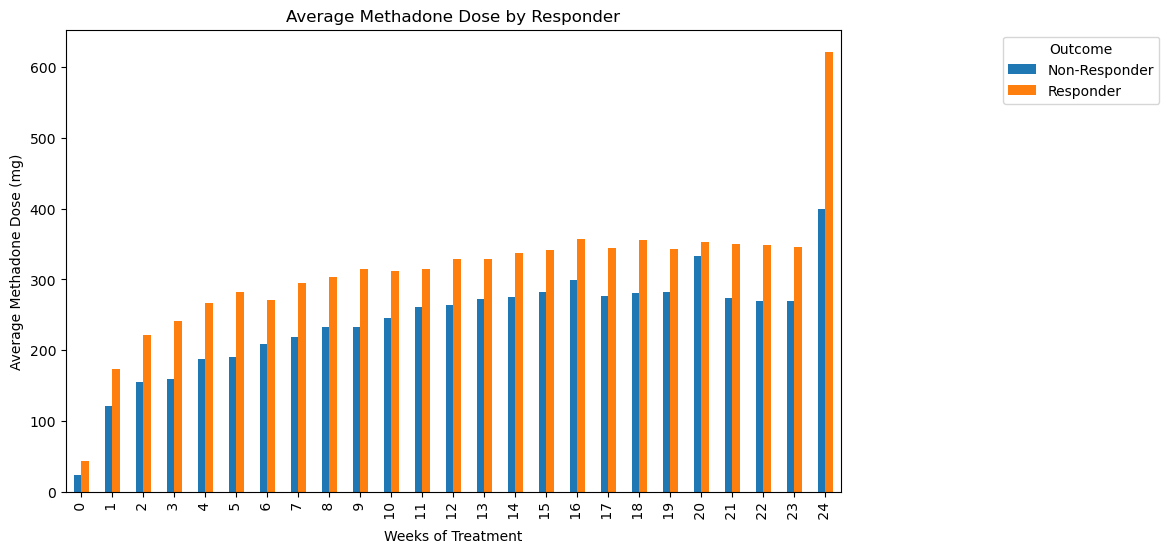

In [11]:
ax = methadone.groupby('responder').mean().round(2).T.plot(kind='bar', figsize=(10,6), legend=False)
ax.set_title('Average Methadone Dose by Responder')
ax.set_xlabel('Weeks of Treatment')
ax.set_ylabel('Average Methadone Dose (mg)')
# legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# edit legend labels ['Non-Responder', 'Responder']]
ax.legend(['Non-Responder', 'Responder'], title='Outcome', bbox_to_anchor=(1.2, 1))


In [12]:
data.columns

Index(['patdeid', 'admin_location_0', 'methadone_dose_0', 'bupe_dose_0',
       'admin_location_1', 'methadone_dose_1', 'bupe_dose_1',
       'admin_location_2', 'methadone_dose_2', 'bupe_dose_2',
       ...
       'race_amer_ind', 'race_Asian', 'race_Black', 'race_pacific_isl',
       'race_White', 'medication', 'total_visits', 'tnt', 'wsu', 'responder'],
      dtype='object', length=558)

In [13]:
bupe = data.loc[:, [col for col in data.columns if 'bupe_dose_' in col]+outcome]

bupe.columns = bupe.columns.str.replace('bupe_dose_', ' ')

bupe

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,responder
0,8.0,160.0,320.0,192.0,384.0,96.0,32.0,352.0,128.0,256.0,...,240.0,152.0,182.0,240.0,210.0,180.0,246.0,128.0,166.0,1
1,8.0,48.0,48.0,60.0,48.0,84.0,84.0,72.0,36.0,72.0,...,64.0,48.0,40.0,40.0,40.0,72.0,60.0,72.0,68.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,16.0,152.0,192.0,160.0,64.0,256.0,256.0,160.0,128.0,192.0,...,224.0,128.0,192.0,192.0,256.0,32.0,160.0,128.0,32.0,0
4,16.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1301,8.0,32.0,64.0,80.0,96.0,56.0,64.0,44.0,24.0,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0


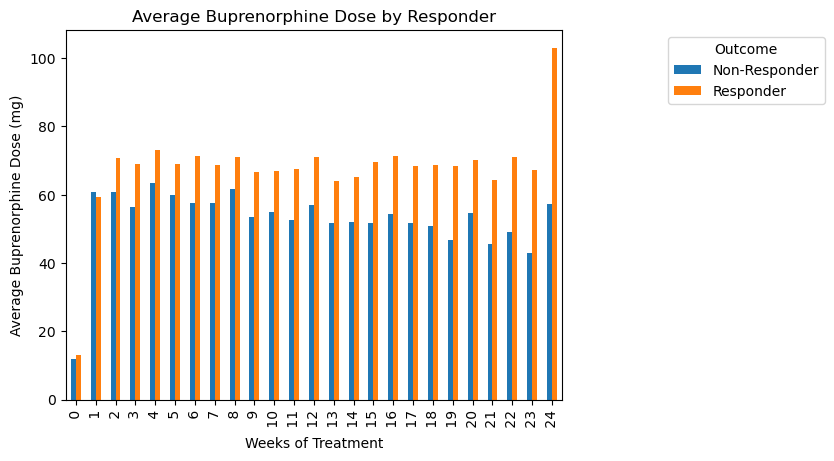

In [14]:
ax = bupe.groupby('responder').mean().round(2).T.plot(kind='bar')
ax.set_title('Average Buprenorphine Dose by Responder')
ax.set_xlabel('Weeks of Treatment')
ax.set_ylabel('Average Buprenorphine Dose (mg)')
# legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# edit legend labels ['Non-Responder', 'Responder']]
ax.legend(['Non-Responder', 'Responder'], title='Outcome', bbox_to_anchor=(1.2, 1))

plt.show()

In [15]:
list(data.columns)

['patdeid',
 'admin_location_0',
 'methadone_dose_0',
 'bupe_dose_0',
 'admin_location_1',
 'methadone_dose_1',
 'bupe_dose_1',
 'admin_location_2',
 'methadone_dose_2',
 'bupe_dose_2',
 'admin_location_3',
 'methadone_dose_3',
 'bupe_dose_3',
 'admin_location_4',
 'methadone_dose_4',
 'bupe_dose_4',
 'admin_location_5',
 'methadone_dose_5',
 'bupe_dose_5',
 'admin_location_6',
 'methadone_dose_6',
 'bupe_dose_6',
 'admin_location_7',
 'methadone_dose_7',
 'bupe_dose_7',
 'admin_location_8',
 'methadone_dose_8',
 'bupe_dose_8',
 'admin_location_9',
 'methadone_dose_9',
 'bupe_dose_9',
 'admin_location_10',
 'methadone_dose_10',
 'bupe_dose_10',
 'admin_location_11',
 'methadone_dose_11',
 'bupe_dose_11',
 'admin_location_12',
 'methadone_dose_12',
 'bupe_dose_12',
 'admin_location_13',
 'methadone_dose_13',
 'bupe_dose_13',
 'admin_location_14',
 'methadone_dose_14',
 'bupe_dose_14',
 'admin_location_15',
 'methadone_dose_15',
 'bupe_dose_15',
 'admin_location_16',
 'methadone_dose_16'

In [16]:
data.groupby('responder').agg({'Sex':'count'})

,Sex
responder,
0,1007
1,298
